# Проектная работа
    Курс: Обучение с учителем
    Тема: Прогнозирование ухода клиента в ближайшее время

# Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Спрогнозируем, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Построим модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, доведем метрику до 0.59. Проверим F1-меру на тестовой выборке самостоятельно.
Дополнительно измерим AUC-ROC, сравним её значение с F1-мерой.

# Цели проекта
    -обучим модель прогнозирующую уход клиентов
    -построим модель с предельно большим значением F1-меры
    -доведем метрику модели F1-меру до 0.59 или более
    -измерим AUC-ROC, сравним её значение с F1-мерой

## Загрузим и подготовим данные. Поясним порядок действий.

### Загрузим и подготовим данные

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sn

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 
from sklearn import metrics
from sklearn.metrics import roc_auc_score

#раздел upsampling
from sklearn.utils import shuffle

In [2]:
#Уберем предупреждения:

#D:\installed\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.if _joblib.__version__ >= LooseVersion('0.12'):
import warnings
warnings.filterwarnings('ignore')

#SettingWithCopy 
#при записи изменённых признаков в исходный датафрейм (особенности поведения sklearn и pandas)
pd.options.mode.chained_assignment = None

#отключим предупреждением библиотеки sklearn при обучении логистической регрессии, 
#укажем аргумент solver='liblinear' (англ. solver «алгоритм решения»; library linear, «библиотека линейных алгоритмов»)

In [3]:
#загрузим датасет с локального компьютера
try:
    df = pd.read_csv('Churn.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/Churn.csv')

In [4]:
#выведем типы признаков данных в таблице
print(df.dtypes)

display(df.head(20))
df.info()
df.describe()

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
#проверим распределение признака
#df['tenure'].hist(bins=10)

### Предобработка данных

In [6]:
#переведем названия признаков в snake_case
print(df.columns) 

df.columns = df.columns.str.lower() # сохраним здесь список в нижнем регистре
df = df.rename(columns={'rownumber': 'row_number',
                        'customerid': 'customer_id',
                        'creditscore': 'credit_score',
                        'numofproducts': 'num_of_products',
                        'hascrcard': 'has_cr_card',
                        'isactivemember': 'is_active_member',
                        'estimatedsalary': 'estimated_salary'
                       }) 
print() 
print(df.columns) 

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


In [7]:
#удалим строки с пропуском признака tenure
df = df.dropna(subset=['tenure']).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB


In [8]:
#удалим столбец чтобы ohe не создал столбец на каждую фамилию
df.info()
df = df.drop(columns=['surname', 'row_number', 'customer_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 994.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Dat

### Корреляция признаков

In [9]:
#оценим графически взаимосвязи в данных и влияние параметров на целевой признак
#sns.pairplot(df, hue="exited")

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
num_of_products,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
has_cr_card,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
is_active_member,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
estimated_salary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029
exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000


<AxesSubplot:>

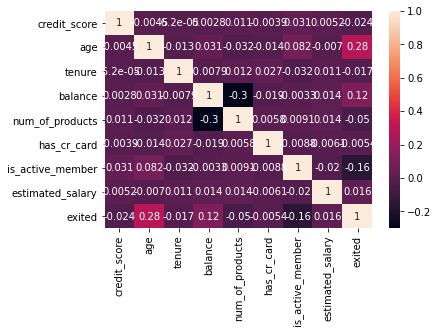

In [10]:
#рассчитаем корреляцию признаков

# Numeric columns of the dataset
numeric_col = ['credit_score','age','tenure','balance','num_of_products',
               'has_cr_card','is_active_member','estimated_salary','exited']

#Correlation Matrix formation
corr_matrix = df.loc[:,numeric_col].corr()
display(corr_matrix)

#Using heatmap to visualize the correlation matrix
sn.heatmap(corr_matrix, annot=True)

### Применим технику прямого кодирования One-Hot Encoding (OHE)

    Наши данные содержат категориальные признаки. 
    Принадлежность к категории к примеру логистическая регрессия вычисляет по формуле, состоящей из признаков. 
    Они могут быть только численные.
    Поэтому применим технику прямого кодирования One-Hot Encoding, OHE. 
    Она подходит для решения нашей задачи: работает со всеми моделями.

In [11]:
#чтобы не попасть в dummy trap , применим аргумент drop_first функции pd.get_dummies(). 
df_ohe = pd.get_dummies(df, drop_first=True)

target = df_ohe['exited'] # извлечем целевой признак
features = df_ohe.drop(['exited'], axis=1) # извлечем признаки 

### Разделим исходные данные на обучающую, валидационную и тестовую выборки.

In [12]:
# отделим выборки, 60% обучающая-train, валидационная 20%, тестовая 20%
# отделим 40% данных для валидационной и тестовой выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345) 
# разделим выборку пополам, получим валидационная 20%, тестовая 20% от исходной
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345) 

print('features', features.shape)
print('features_train', features_train.shape)
print('features_valid_test', features_valid_test.shape)
print('features_valid', features_valid.shape)
print('features_test', features_test.shape)

features (9091, 11)
features_train (5454, 11)
features_valid_test (3637, 11)
features_valid (1818, 11)
features_test (1819, 11)


In [13]:
#объединим выборки для лучшего обучения перед проверкой на тестовой
features_train_valid = pd.concat([features_train, features_valid], axis=0)
target_train_valid   = pd.concat([target_train, target_valid], axis=0)

print('features_train', features_train.shape)
print('features_valid', features_valid.shape)
print('features_train_valid', features_train_valid.shape)

features_train (5454, 11)
features_valid (1818, 11)
features_train_valid (7272, 11)


### Применим масштабирование признаков методом стандартизации данных

In [14]:
features_train.info()
display(features_train.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5454 entries, 8483 to 4578
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       5454 non-null   int64  
 1   age                5454 non-null   int64  
 2   tenure             5454 non-null   float64
 3   balance            5454 non-null   float64
 4   num_of_products    5454 non-null   int64  
 5   has_cr_card        5454 non-null   int64  
 6   is_active_member   5454 non-null   int64  
 7   estimated_salary   5454 non-null   float64
 8   geography_Germany  5454 non-null   uint8  
 9   geography_Spain    5454 non-null   uint8  
 10  gender_Male        5454 non-null   uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 399.5 KB


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8483,727,28,2.0,110997.76,1,1,0,101433.76,0,0,0
3431,537,26,7.0,106397.75,1,0,0,103563.23,0,0,1
6770,610,40,9.0,0.00,1,1,1,149602.54,0,0,1
1350,576,36,6.0,0.00,2,1,1,48314.00,0,0,1
4047,549,31,4.0,0.00,2,0,1,25684.85,0,0,1


In [15]:
#внесем в список все численные признаки
numeric = ['credit_score', 
           'age',
           'tenure',
           'balance',
           'num_of_products', 
           'has_cr_card', 
           'is_active_member', 
           'estimated_salary',
           'geography_Germany',
           'geography_Spain',
           'gender_Male'
          ]

#создадим объект структуры StandardScaler и настроим его на обучающих данных. Настройка — вычисление среднего и дисперсии
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train_valid[numeric] = scaler.transform(features_train_valid[numeric])

In [16]:
#посмотрим на результат масштабирования
display(features_train.head())
features_train.info()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
8483,0.809075,-1.039327,-1.025995,0.554904,-0.908179,0.663468,-1.024127,0.019508,-0.58229,-0.572128,-1.107304
3431,-1.152518,-1.227561,0.696524,0.480609,-0.908179,-1.507231,-1.024127,0.056167,-0.58229,-0.572128,0.903094
6770,-0.398853,0.090079,1.385532,-1.237830,-0.908179,0.663468,0.976442,0.848738,-0.58229,-0.572128,0.903094
1350,-0.749875,-0.286389,0.352020,-1.237830,0.809300,0.663468,0.976442,-0.894953,-0.58229,-0.572128,0.903094
4047,-1.028628,-0.756975,-0.336987,-1.237830,0.809300,-1.507231,0.976442,-1.284516,-0.58229,-0.572128,0.903094


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5454 entries, 8483 to 4578
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       5454 non-null   float64
 1   age                5454 non-null   float64
 2   tenure             5454 non-null   float64
 3   balance            5454 non-null   float64
 4   num_of_products    5454 non-null   float64
 5   has_cr_card        5454 non-null   float64
 6   is_active_member   5454 non-null   float64
 7   estimated_salary   5454 non-null   float64
 8   geography_Germany  5454 non-null   float64
 9   geography_Spain    5454 non-null   float64
 10  gender_Male        5454 non-null   float64
dtypes: float64(11)
memory usage: 511.3 KB


### Вывод
    -пропуски в признаке Tenure, около 9%. Удалим объекты (строки) с пропусками по данному признаку, т.к заменять на ноль нельзя - это нарушит обучение модели, оставлять пропуски нельзя, с ними не работают модели, заменять средним и медианой также нельзя - на таких данных нельзя обучать.
    -названия признаков переведем перевести в snake_case
    -есть несколько категориальных признаков, например Geography, Gender, поэтому применим OHE
    -целевой признак Exited, около 20% клиентов из данного датасета - расторгли договор обслуживания (mean 0.203700)
    -сила связи набра признаков с целевым признаком по шкале Чеддока -очень слабая, наиболее высокая сила связи (из имеющихся ) с признаком возраст -0.283017

## Исследуем баланс классов, обучим модель без учёта дисбаланса. Кратко опишем выводы.

### Проверка адекватности модели

0    0.796062
1    0.203938
Name: exited, dtype: float64


<AxesSubplot:>

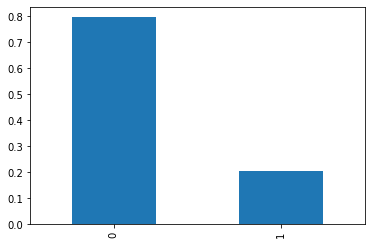

In [17]:
#для подсчёта классов в целевом признаке применим метод value_counts(). Сделаем частоты относительными (от 0 до 1)
class_frequency = df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') #построим диаграмму

In [18]:
#уберем дубликат, ниже уже обучили DecisionTreeClassifier

#model = DecisionTreeClassifier(random_state=12345)
#model.fit(features_train, target_train)

# чтобы работала функция value_counts(),
# мы преобразовали результат к pd.Series 
#predicted_valid = pd.Series(model.predict(features_valid))

#class_frequency = predicted_valid.value_counts(normalize=True)
#print(class_frequency)
#class_frequency.plot(kind='bar') #построим диаграмму

 #### Комментарий студента
     F1 ниже, выше код взят из теории, так учили проверять дисбаланс


In [19]:
#Создадим константную модель: любому объекту она прогнозирует класс «0» и Сохраните её предсказания в target_pred_constant.
target_pred_constant =  pd.Series(0, index=target.index) 

#Посчитаем accuracy и f1 константной модели
print("accuracy_score:: {0:.3f} ".format(accuracy_score(target, target_pred_constant)))
print('f1_score:', f1_score(target, target_pred_constant))

accuracy_score:: 0.796 
f1_score: 0.0


### F1-мера + AUC-ROC LogisticRegression (обучение - train, проверка f1 и auc_roc - valid)

In [20]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
print("f1_score:: {0:.3f} ".format(f1_score(target_valid, predicted_valid)))

#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

f1_score:: 0.303 
auc_roc: 0.774 


### F1-мера + AUC-ROC DecisionTreeClassifier (обучение - train, проверка f1 auc_roc - valid)
Агрегирующая метрика, (англ. F1-score) - среднее гармоническое полноты и точности. Единица в F1 означает, что соотношение полноты и точности равно 1:1.

In [21]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1_score:: {0:.3f} ".format(f1_score(target_valid, predicted_valid)))

#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

f1_score:: 0.493 
auc_roc: 0.680 


### F1-мера  + AUC-ROC RandomForestClassifier + GridSearchCV (обучение grid и model - train, проверка f1 и auc_roc - valid)

In [ ]:
%%time

#объявляем классификатор RandomForest, не внося в него никаких параметров
model = RandomForestClassifier()

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, а нам нужно фикс значение random_state, поэтому поставим диапазон (12345, 12346, 10)
parametrs = { 'random_state': range (12345, 12346, 10), 
              'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 15, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2),
            }

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = GridSearchCV(model, parametrs, cv=5, n_jobs = -1, scoring='f1', verbose=True)
grid.fit(features_train, target_train)

#выводим лучшие параметры
grid.best_params_

Fitting 5 folds for each of 980 candidates, totalling 4900 fits


#### grid.best_params_
     
     Wall time: 2min 20s
    {'max_depth': 13,
     'min_samples_leaf': 2,
     'min_samples_split': 6,
     'n_estimators': 40,
     'random_state': 12345}
     f1_score: 0.582 
     auc_roc: 0.867 

In [ ]:
# обучим модель на тренировочной выборке
#model = grid.best_estimator_
model = RandomForestClassifier(random_state=12345, n_estimators=40, min_samples_split=6, min_samples_leaf=2, max_depth=13) 
model.fit(features_train, target_train) 
# узнаем и сохраним предсказания на валидационной выборке
predicted_valid = model.predict(features_valid)
# узнаем и сохраним f1 на валидационной выборке
result = f1_score(target_valid, predicted_valid)
print("f1_score: {0:.3f} ".format(result))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

### F1-мера + AUC-ROC RandomForestClassifier + RandomizedSearchCV (обучение grid и model - train, проверка f1 и auc_roc - valid)

In [ ]:
%%time

#объявляем классификатор RandomForest, не внося в него никаких параметров
model = RandomForestClassifier()

#создаем словарь, в который вписываем параметры, которые будем прогонять 
#инструмент работает с диапазоном, а нам нужно фикс значение random_state, поэтому схитрим с диапазоном - (12345, 12346, 10)
parametrs = { 'random_state': range (12345, 12346, 10), 
              'n_estimators': range (10, 110, 10),
              'max_depth': range (1, 50, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 15, 1) }

#запускаем обучениеи
#n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП
grid = RandomizedSearchCV(model, parametrs, cv=5, n_jobs = -1, scoring='f1', n_iter=1000, verbose=True)
grid.fit(features_train, target_train)

#выводим лучшие параметры
grid.best_params_

In [ ]:
%%time

# обучим модель на тренировочной выборке
#model = grid.best_estimator_
model = RandomForestClassifier(random_state=12345, n_estimators=100, min_samples_split=12, min_samples_leaf=1, max_depth=47) 
model.fit(features_train, target_train) 
# узнаем и сохраним предсказания на валидационной выборке
predicted_valid = model.predict(features_valid)
# узнаем и сохраним f1 на валидационной выборке
result = f1_score(target_valid, predicted_valid)
print("f1_score: {0:.3f} ".format(result))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

### F1-мера + AUC-ROC RandomForestClassifier + "Полуавтомат" (подбор и model - train, проверка f1 и auc_roc - valid)

In [ ]:
#Подберем параметры модели "полуавтоматическим" методом

best_model = None

best_f1 =    0
best_depth = 0
best_est =   0
best_split = 0
best_leaf =  0

#****************************************1 max_depth
for depth in range(1, 30, 1):
    model =  RandomForestClassifier(random_state=12345, 
                                    n_estimators=  20, 
                                    max_depth=     depth, 
                                
                                    )# инициализируйте модель 
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('depth', depth, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print("f1 наилучшей модели:", best_f1, 
      "Максимальная глубина:", best_depth
     )

#****************************************2 n_estimators
print() 
best_f1 =    0
for est in range(10, 50, 1):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=   est, 
                                   max_depth=      best_depth, 
                                   
                                   )
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('n_estimators', est, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_est = est       
print("f1 наилучшей модели:", best_f1, 
      "Количество деревьев:", best_est
     )

#****************************************3 min_samples_split
print() 
best_f1 =    0
for split in range(2, 30, 1):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=         best_est, 
                                   max_depth=            best_depth, 
                                   min_samples_split=    split,
                                   
                                   )
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('split', split, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_split = split       
print("f1 наилучшей модели:", best_f1, 
      "Количество split:", best_split
     )

#****************************************4 min_samples_leaf
print() 
best_f1 =    0
for leaf in range(1, 30):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=        best_est, 
                                   max_depth=           best_depth,
                                   min_samples_split=   best_split,
                                   min_samples_leaf=    leaf,
                                   
                                   )
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('leaf', leaf, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_leaf = leaf       
print("f1 наилучшей модели:", best_f1, 
      "Количество leaf:", best_leaf
     )

print("f1 наилучшей модели:", best_f1, 
      "Максимальная глубина:", best_depth, 
      "Количество деревьев:", best_est,
      "Количество split:", best_split,
      "Количество leaf:", best_leaf
     )

    гиперпараметры подобранные полуавтоматом выше:
    f1 наилучшей модели: 0.6012861736334405 
    Максимальная глубина: 19 
    Количество деревьев: 13 
    Количество split: 9 
    Количество leaf: 1

In [ ]:
# обучим модель на тренировочной выборке
model = RandomForestClassifier(random_state=12345, 
                               n_estimators=13, 
                               max_depth=19, 
                               min_samples_split=9, 
                               min_samples_leaf=1, 
                               ) 

model.fit(features_train, target_train) 
# узнаем и сохраним предсказания на валидационной выборке
predicted_valid = model.predict(features_valid)
# узнаем и сохраним f1 на валидационной выборке
result = f1_score(target_valid, predicted_valid)
print("f1_score на валидационной выборке: {0:.3f} ".format(result))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

### Вывод
    -присутствует дисбаланс классов по целевому признаку, 1 - 20%
    -максимальное значение F1-мера удалось достичь используя модель RandomForestClassifier + поиск параметров методом  RandomizedSearchCV, обучение grid и model произвели на выборке train, проверка f1 проведена на выборке - valid
    -целевое значение F1-мера 0,59 без учета дисбаланса достигнуто подбором параметров полуавтоматом
    
    ГП полученные в 2.5 не будем пока что сбрасывать со счетов
    model = RandomForestClassifier(random_state=12345, n_estimators=100, min_samples_split=12, min_samples_leaf=1, max_depth=47) 
    Даже не смотря на то что получили значения "ниже:
    f1_score на валидационной выборке: 0.573 
    auc_roc: 0.869 

## Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Кратко опишем выводы.
Чтобы увеличить качество модели при дисбалансе классов, проверим техники: взвешивание классов и upsampling.


### Техника увеличения качества модели при дисбалансе классов: Взвешивание классов (class_weight='balanced')
    Если указать class_weight='balanced' (англ. «сбалансированный»),  алгоритм посчитает, во сколько раз класс «0» встречается чаще класса «1». 
    Обозначим это число N (неизвестное количество раз). Новые веса классов выглядят так:
        вес класса «0» = 1.0
        вес класса «1» = N
    Бóльший вес будет у редкого класса.
    Аргумент class_weight есть у логистической регрессии, решающего дерева и случайного леса.

In [ ]:
#Подберем параметры модели "полуавтоматическим" методом

best_model = None

best_f1 =    0
best_depth = 0
best_est =   0
best_split = 0
best_leaf =  0

#****************************************1 max_depth
for depth in range(1, 30, 1):
    model =  RandomForestClassиifier(random_state=12345, 
                                    n_estimators=  20, 
                                    max_depth=     depth, 
                                    
                                    class_weight='balanced')# инициализируйте модель 
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('depth', depth, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
print("f1 наилучшей модели:", best_f1, 
      "Максимальная глубина:", best_depth
     )

#****************************************2 n_estimators
print() 
best_f1 =    0
for est in range(10, 50, 1):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=   est, 
                                   max_depth=      best_depth, 
                                   
                                   class_weight='balanced')
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('n_estimators', est, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_est = est       
print("f1 наилучшей модели:", best_f1, 
      "Количество деревьев:", best_est
     )

#****************************************3 min_samples_split
print() 
best_f1 =    0
for split in range(2, 30, 1):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=         best_est, 
                                   max_depth=            best_depth, 
                                   min_samples_split=    split,
                                   
                                   class_weight='balanced')
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('split', split, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_split = split       
print("f1 наилучшей модели:", best_f1, 
      "Количество split:", best_split
     )

#****************************************4 min_samples_leaf
print() 
best_f1 =    0
for leaf in range(1, 30):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators=        best_est, 
                                   max_depth=           best_depth,
                                   min_samples_split=   best_split,
                                   min_samples_leaf=    leaf,
                                   
                                   class_weight='balanced')
    
    model.fit(features_train, target_train) # обучите модель  
    predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания 
    f1 = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 
    print('leaf', leaf, 'f1', f1)
    if f1 > best_f1:
        best_f1 = f1
        best_leaf = leaf       
print("f1 наилучшей модели:", best_f1, 
      "Количество leaf:", best_leaf
     )

print("f1 наилучшей модели:", best_f1, 
      "Максимальная глубина:", best_depth, 
      "Количество деревьев:", best_est,
      "Количество split:", best_split,
      "Количество leaf:", best_leaf
     )

    ГП полуавтомата выше:
    f1 наилучшей модели: 0.654275092936803 
    Максимальная глубина: 12 
    Количество деревьев: 16 
    Количество split: 19 
    Количество leaf: 1

#### F1-мера + AUC-ROC LogisticRegression + class_weight='balanced'

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1_score:: {0:.3f} ".format(f1_score(target_valid, predicted_valid)))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

#### F1-мера + AUC-ROC DecisionTreeClassifier + class_weight='balanced'

In [ ]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1_score:: {0:.3f} ".format(f1_score(target_valid, predicted_valid)))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

#### F1-мера + AUC-ROC RandomForestClassifier + RandomizedSearchCV + class_weight='balanced'

In [ ]:
# обучим модель на тренировочной выборке
model = RandomForestClassifier(
    random_state=12345, n_estimators=100, min_samples_split=12, min_samples_leaf=1, max_depth=47, class_weight='balanced') 
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания на валидационной выборке
result = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 на валидационной выборке
print("f1_score: {0:.3f} ".format(result))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

### Техника увеличения качества модели при дисбалансе классов: upsampling
Эта техника позволяет сделать объекты редкого класса не такими редкими и важные задачи повторяются по несколько раз, чтобы их легче запомнить модели.

In [ ]:
#функция для upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

#сравняем количество 0 и 1, домножив 1 на 4
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера:</b>
    
Молодец, правильно используешь функции из тренажера.

</div>

#### F1-мера + AUC-ROC LogisticRegression + upsampling

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear')
#обучим на upsampled данных
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("f1_score:: {0:.3f} ".format(f1_score(target_valid, predicted_valid)))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

#### F1-мера + AUC-ROC DecisionTreeClassifier + upsampling

In [ ]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("f1_score:: {0:.3f} ".format(f1_score(target_valid, predicted_valid)))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

#### F1-мера + AUC-ROC RandomForestClassifier + RandomizedSearchCV + upsampling

In [ ]:
model = RandomForestClassifier(
    random_state=12345, n_estimators=100, min_samples_split=12, min_samples_leaf=1, max_depth=47) 
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) #рассчитаем и сохраним предсказания на валидационной выборке
result = f1_score(target_valid, predicted_valid) #рассчитаем и сохраним f1 на валидационной выборке
print("f1_score: {0:.3f} ".format(result))


#AUC-ROC
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc_roc: {0:.3f} ".format(auc_roc))

### Вывод
    -применение параметра class_weight='balanced' и техники upsampling позволило увеличить значение F1-мера и auc_roc.
    
                            без учета д/б    balanced    balanced+полуавт      upsampling  
    LogisticRegression      0.303*           0.510       -                     0.508 
    DecisionTreeClassifier  0.493            0.473       -                     0.462     
    RandomForestClassifier  0.587            0.645       0.654*                0.627                
    
    
    -применение параметра  class_weight='balanced' техники upsampling позволило достичь целового значения метрики F1-мера 
    для модели RandomForestClassifier   
    -также значение F1-мера выше чем у других моделей, достигнуто у RandomForestClassifier благодаря подбору параметров.

## Проведем финальное тестирование
   

### F1-мера + AUC-ROC RandomForestClassifier + GridSearchCV / RandomizedSearchCV + class_weight='balanced' 
(обучение на train_valid)

In [ ]:
# обучим модель на тренировочной и валидационной выборке
model = RandomForestClassifier(
    random_state=12345, n_estimators=100, min_samples_split=12, min_samples_leaf=1, max_depth=47, class_weight='balanced')  
model.fit(features_train_valid, target_train_valid) 
predicted_test = model.predict(features_test) #рассчитаем и сохраним предсказания 
result = f1_score(target_test, predicted_test) #рассчитаем и сохраним f1 
print("f1_score: {0:.3f} ".format(result))


#AUC-ROC
probabilities_valid = model.predict_proba(features_test)
probabilities_one_test = probabilities_valid[:, 1]
#рассчитаем AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("auc_roc: {0:.3f} ".format(auc_roc))


# Save to file in the current working directory 
dump(model, 'model_randomforestclassifier_balanced.joblib')

### Измерим AUC-ROC, сравним её значение с F1-мерой

In [ ]:
# Load best model from file 
model = joblib.load('model_randomforestclassifier_balanced.joblib')

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()

#постороим график: ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
#примените функции plt.xlim() и plt.ylim(), чтобы  установить границы осей от 0 до 1
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

#применим функции plt.xlabel() и plt.ylabel(), чтобы подписать оси "False Positive Rate" и "True Positive Rate"
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#добавим к графику заголовок "ROC-кривая" функцией plt.title()
plt.title('ROC-кривая')

plt.show()

In [ ]:
#посчитаем для RandomForestClassifier AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("auc_roc:", auc_roc)

### Вывод
    -наибольшее значение метрики достигнуто на модели RandomForestClassifier f1_score: 0.632 
    -модель сохранена для последующего вызова при подсчете auc_roc
    -получено значение auc_roc: 0.863,
    -auc_roc > F1-мера

## Общий вывод
    -обучили модель прогнозирующую уход клиентов
    -построили модель с предельно большим значением F1-меры
    -довели метрику модели F1-меру до 0.59, получили значение выше на тесте - 0.632
    -измерили auc_roc: 0.863, сравнили её значение с F1-мерой, auc_roc > F1-мера         